
$$
\begin{array}{ll}
\underset{\mathbf{p}, \mathbf{v}, \mathbf{a}}{\operatorname{min}} &\sum\limits_{i}^{\{x, y, z\}} \left( \sum\limits_{n=0}^{N}  
\|\mathbf{a}_n^i\|^2_2  + \|\mathbf{p}_N^i - \mathbf{p}^{i, \mathrm{d}}\|^2_2 +\|\mathbf{v}_N^i - \mathbf{v}^{i, \mathrm{d}}\|^2_2  \right)\\
\text { s.t.} & 
\mathbf{p_0} = \mathbf{p}_0^\mathrm{des};\mathbf{v_0} = \mathbf{v}_0^\mathrm{des} \\
& \mathbf{v}_n \in \mathcal{V}; \mathbf{a}_n \in \mathcal{A} \\
& \mathbf{p}_{n+1} = \mathbf{p}_n  +\mathbf{v}_n \mathrm{\Delta t} \\
& \mathbf{v}_{n+1} = \mathbf{v}_n + \mathbf{a}_n \mathrm{\Delta t} \\
& p_{n_k:n_{k+\xi}}^z = p_{\mathrm{height}} \quad \text{ (trapezoidal profile)}
\end{array}
$$

In [1]:
import cvxpy as cp
import numpy as np
print(cp.installed_solvers())

['ECOS', 'ECOS_BB', 'MOSEK', 'OSQP', 'SCIPY', 'SCS']


In [2]:
Ts = 0.3
dt = 0.01
N = int(Ts/dt)

p_N_des = np.array([0.2, 0.2, 0.0])
v_N_des = np.zeros(3)
p_0_des = np.array([0.0, 0.0, 0.0])
v_0_des = np.zeros(3)

foot_height_keep = 0.2
opt_weight_desired_pos = np.array([5500, 5500, 55000])
opt_weight_desired_vel = np.array([5500, 5500, 55000])
weight_acc_square = 0.001

px = cp.Variable(N)
vx = cp.Variable(N)
ax = cp.Variable(N)
py = cp.Variable(N)
vy = cp.Variable(N)
ay = cp.Variable(N)
pz = cp.Variable(N)
vz = cp.Variable(N)
az = cp.Variable(N)


objective = cp.Minimize(weight_acc_square * cp.sum_squares(ax) + weight_acc_square * cp.sum_squares(ay) + weight_acc_square * cp.sum_squares(az) + \
                        opt_weight_desired_pos[0] * cp.square(px[N - 1] - p_N_des[0]) + \
                        opt_weight_desired_vel[0] * cp.square(py[N - 1] - p_N_des[1]) + \
                        opt_weight_desired_pos[1] * cp.square(pz[N - 1] - p_N_des[2]) + \
                        opt_weight_desired_vel[1] * cp.square(vx[N - 1] - v_N_des[0]) + \
                        opt_weight_desired_pos[2] * cp.square(vy[N - 1] - v_N_des[1]) + \
                        opt_weight_desired_vel[2] * cp.square(vz[N - 1] - v_N_des[2])
)
constraints = []
# Initial Condition Constraints
constraints += [px[0] == p_0_des[0],
                vx[0] == v_0_des[0],
                py[0] == p_0_des[1],
                vy[0] == v_0_des[1],
                pz[0] == p_0_des[2],
                vz[0] == v_0_des[2]]

# Dynamics Constraints
for k in range(N-1): 
    constraints.append(px[k+1] == px[k] + vx[k]*dt)
    constraints.append(vx[k+1] == vx[k] + ax[k]*dt)
    constraints.append(py[k+1] == py[k] + vy[k]*dt)
    constraints.append(vy[k+1] == vy[k] + ay[k]*dt)
    constraints.append(pz[k+1] == pz[k] + vz[k]*dt)
    constraints.append(vz[k+1] == vz[k] + az[k]*dt)

# Limits
a_max = 100
a_min = -100
v_max = 10
v_min = -10

for k in range(N):
    constraints += [a_min <= ax[k], ax[k] <= a_max]
    constraints += [a_min <= ay[k], ay[k] <= a_max]
    constraints += [a_min <= az[k], az[k] <= a_max]
    constraints += [v_min <= vx[k], vx[k] <= v_max]
    constraints += [v_min <= vy[k], vy[k] <= v_max]
    constraints += [v_min <= vz[k], vz[k] <= v_max]

# Foot certain height
T_keep = 30.0/100*Ts
T_start_keep = 30.0/100*Ts
T_end_keep = T_keep + T_start_keep
n_keep = int(T_keep/dt)
n_start_keep = int(T_start_keep/dt)
n_end_keep = n_keep + n_start_keep
for k in range(n_start_keep, n_end_keep):
    constraints += [pz[k] == foot_height_keep]

prob = cp.Problem(objective, constraints)
result = prob.solve(verbose=True, solver=cp.OSQP, max_iter=200000)
print("The number of iterations is", prob.solver_stats)



                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Jul 27 11:27:49 AM: Your problem has 270 variables, 549 constraints, and 0 parameters.
(CVXPY) Jul 27 11:27:50 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 27 11:27:50 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 27 11:27:50 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 27 11:27:50 AM: Compiling problem (target solver=OSQP).
(CVXPY) Jul 27 11:27:50 AM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuff

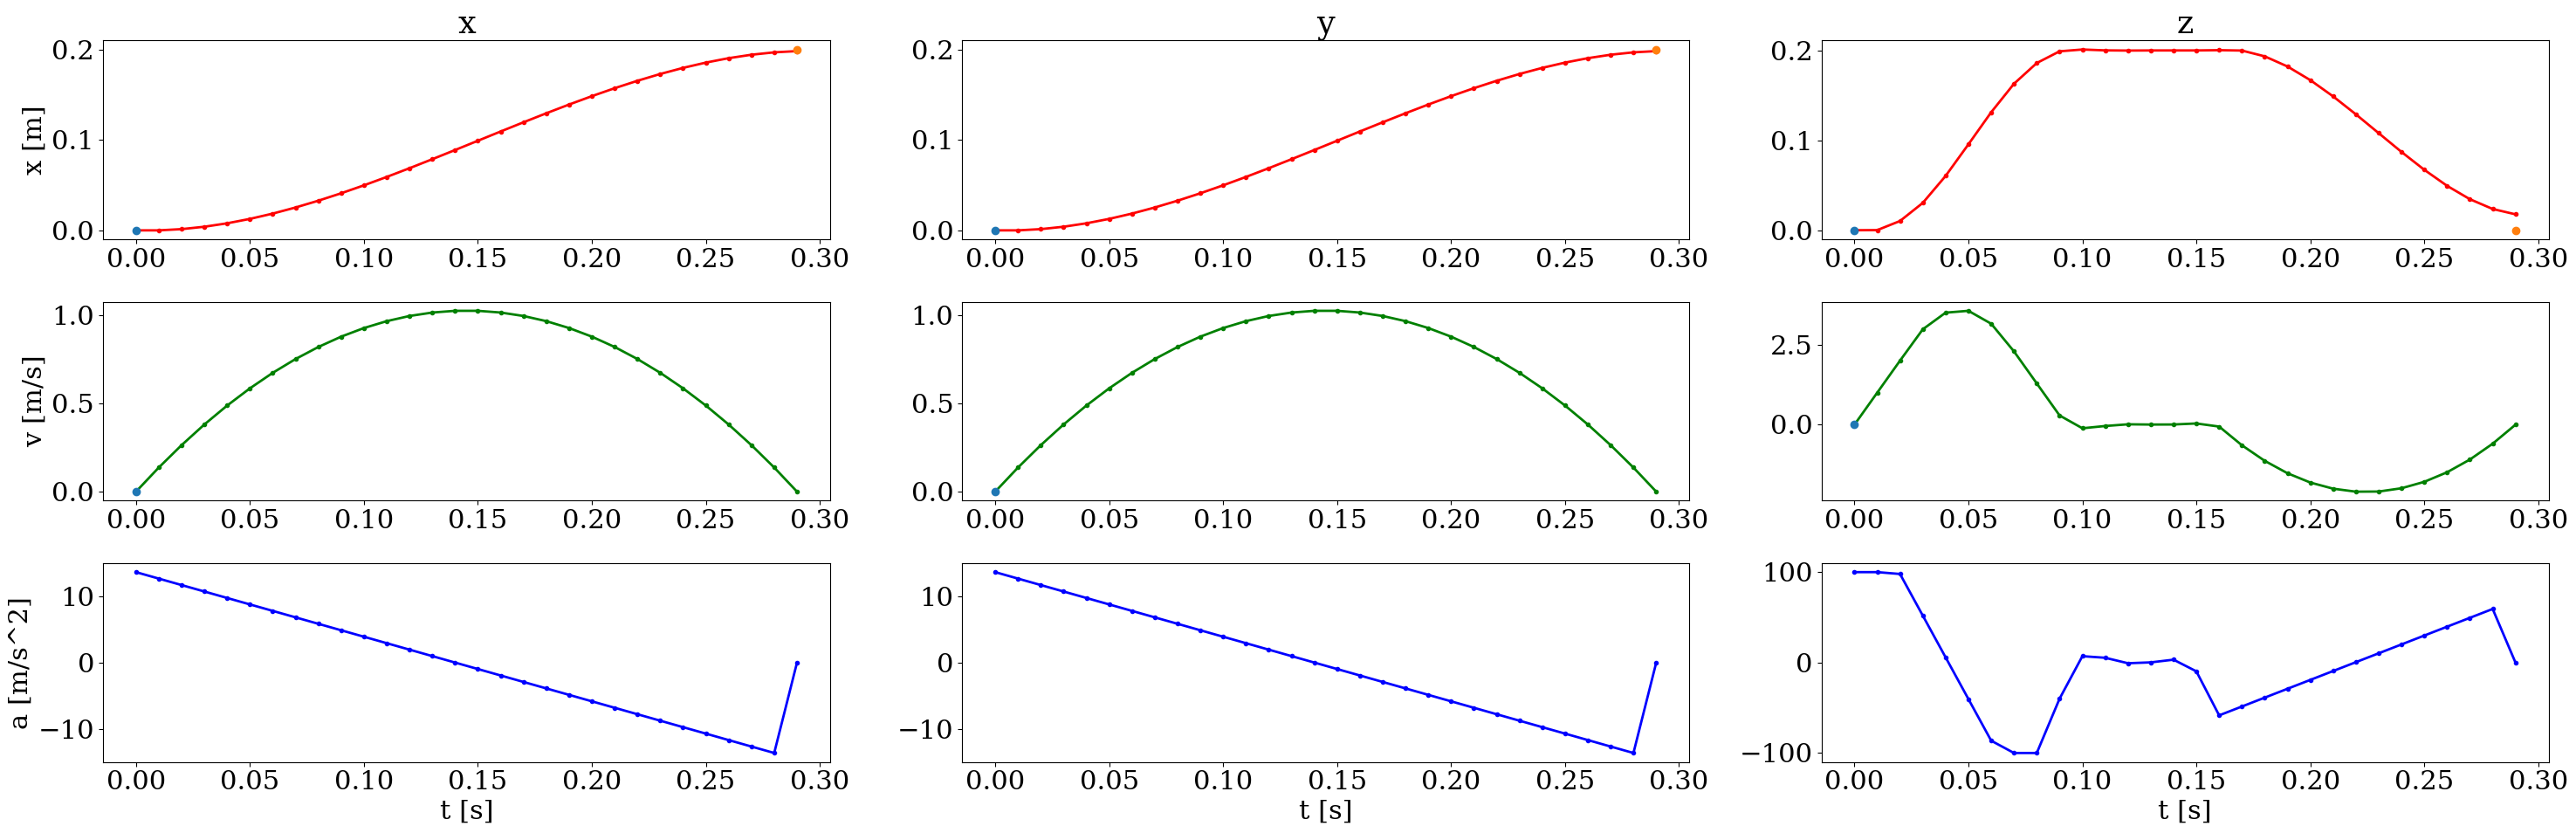

In [3]:
import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.size': 22,
    'font.family': 'serif',
    'mathtext.default': 'regular',
    'axes.labelsize': 22,
    'xtick.labelsize': 22,
    'ytick.labelsize': 22,
    'legend.fontsize': 22,
    'figure.titlesize': 22,
    'lines.linewidth': 2,
})

fig, axs = plt.subplots(3, 3, figsize=(30, 10))
t = np.arange(0, Ts, dt)
axs[0, 0].set_title('x')
axs[0, 0].plot(t, px.value, '.-r', label='pos')
axs[0, 0].plot(0, p_0_des[0], 'o')
axs[0, 0].set_ylabel('x [m]')
axs[0, 0].plot(t[-1], p_N_des[0], 'o')
axs[1, 0].plot(t, vx.value, '.-g', label='vel')
axs[1, 0].plot(0, v_0_des[0], 'o')
axs[1, 0].set_ylabel('v [m/s]')
# axs[1].plot(t[-1], v_N_desired, 'o')
axs[2, 0].plot(t, ax.value, '.-b', label='acc')
axs[2, 0].set_ylabel('a [m/s^2]')
axs[2, 0].set_xlabel('t [s]')

axs[0, 1].set_title('y')
axs[0, 1].plot(t, py.value, '.-r', label='pos')
axs[0, 1].plot(0, p_0_des[1], 'o')
axs[0, 1].plot(t[-1], p_N_des[1], 'o')
axs[1, 1].plot(t, vy.value, '.-g', label='vel')
axs[1, 1].plot(0, v_0_des[0], 'o')
# axs[1].plot(t[-1], v_N_desired, 'o')
axs[2, 1].plot(t, ay.value, '.-b', label='acc')
axs[2, 1].set_xlabel('t [s]')

axs[0, 2].set_title('z')
axs[0, 2].plot(t, pz.value, '.-r', label='pos')
axs[0, 2].plot(0, p_0_des[2], 'o')
axs[0, 2].plot(t[-1], p_N_des[2], 'o')
axs[1, 2].plot(t, vz.value, '.-g', label='vel')
axs[1, 2].plot(0, v_0_des[1], 'o')
# axs[1].plot(t[-1], v_N_desired, 'o')
axs[2, 2].plot(t, az.value, '.-b', label='acc')
axs[2, 2].set_xlabel('t [s]')

plt.tight_layout()
# [a.legend() for a in axs]
plt.show()
